### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor,)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

### Setting up a database object

We connect to the 'real' tenant's database to update the model store

In [2]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2021-11-26T10:09:23.124 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
2021-11-26T10:09:23.125 WARNING iotfunctions.db.__init__ Unable to locate CORE API URL.. using base API URL
2021-11-26T10:09:34.807 INFO iotfunctions.db.__init__ Data Dictionary is not available.


### Loading and minimally cleansing pump data

The CSV file contains sensor readings for two pumps with ids '04714B6046D5' and '04714B604101'

In [3]:
# load data
df_input = pd.read_csv('./data/AllOfArmstark.csv', parse_dates=['timestamp'], comment='#')
#df_input = df_input.asfreq('H')
df_input = df_input.sort_values(by='timestamp').set_index('timestamp')

#df_temp = df_input[['Vx']].shift(1, freq='1D')
df_input['Vx_1'] = df_input[['Vx']].shift(1440) # not used for any particular purpose
df_input.dropna(inplace=True)

df_input = df_input.reset_index().set_index(['entity','timestamp'])



In [24]:
# make it plottable
sz = 500
df_input['max'] = sp.ndimage.maximum_filter1d(df_input['Vx'], size=sz)

In [31]:
df_input.index.levels[0][1]

'04714B6046D5'

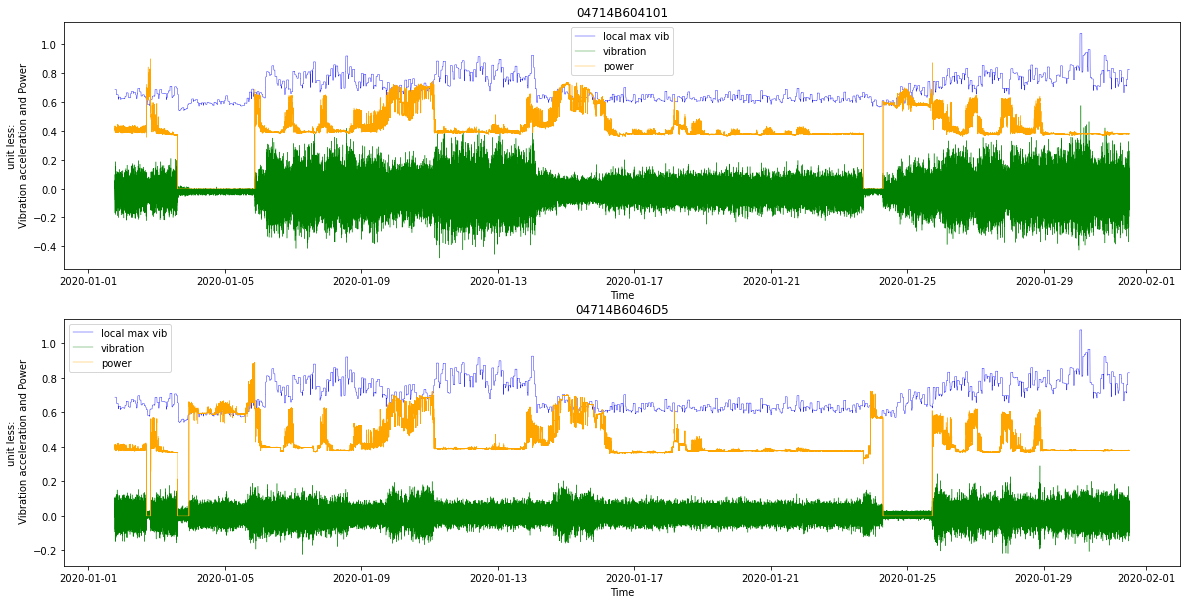

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), squeeze=False)
i = 0
for tag in df_input.index.levels[0]:
    ax[i,0].plot(df_input.loc[tag]['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
    ax[i,0].plot(df_input.loc[tag]['Vx'], lw=0.4, color='green', label='vibration')
    ax[i,0].plot(df_input.loc[tag]['Ap']/6, lw=0.4, color='orange', label='power')
    ax[i,0].legend()
    ax[i,0].set_title(tag)
    ax[i,0].set_xlabel('Time')
    ax[i,0].set_ylabel('unit less:\n Vibration acceleration and Power')
    i+=1



In [15]:
# just in case ...
df_i = df_input.copy()

In [14]:
#group_base = [pd.Grouper(axis=0, level=0)]
#df_i.groupby(group_base).apply(lambda x: print('here', x.index[0][0]))

### Training a small VAE
2 layers for mean, 3 layers for sigma

In [20]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

viai = VIAnomalyScore(['Ap'], ['Vx'])

#viai.delete_model = True  # make sure old models are deleted
viai.auto_train = True  # enforce training
viai.epochs = 80        # suffices

et = viai._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
viai._entity_type = et
df_i = viai.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()

2021-11-26T11:46:46.598 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-11-26T11:46:46.599 DEBUG root.__init__ __init__VIAnomalyScore
2021-11-26T11:46:46.599 DEBUG root.__init__ __init__ done with parameters: Ap.Vx
2021-11-26T11:46:46.603 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.7.0
2021-11-26T11:46:46.604 DEBUG iotfunctions.util.__init__ Starting trace
2021-11-26T11:46:46.605 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20211126104646
2021-11-26T11:46:46.605 DEBUG iotfunctions.util.__init__ auto_save None
2021-11-26T11:46:46.606 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-11-26T11:46:46.606 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2021-11-26T11:46:46.606 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_VIANOMALYSCORE
Fu

,Vx,Vy,Vz,Ap,As,speed,Vx_1,predicted_Vx,pred_dev_Vx
count,257055.000000,257055.000000,257055.000000,257055.000000,257055.000000,257055.000000,257055.000000,257055.000000,257055.000000
mean,-0.006536,-0.027381,-0.959089,2.431164,0.970914,0.971130,-0.006535,-0.006931,0.216680
std,0.061941,0.037634,0.073462,0.906289,0.289532,0.288927,0.061808,0.014953,0.070436
min,-0.481400,-0.359400,-1.415000,0.000000,0.000000,0.000000,-0.481400,-0.037002,0.067248
25%,-0.034200,-0.044900,-0.999000,2.260000,1.032000,1.031694,-0.034200,-0.022233,0.162461
50%,-0.003900,-0.027300,-0.960000,2.330200,1.037000,1.037000,-0.003900,0.004483,0.192151
75%,0.027300,-0.009800,-0.922900,2.687200,1.057000,1.058038,0.027300,0.008094,0.289794
max,0.575200,0.286100,-0.474600,5.401600,1.201000,1.195605,0.575200,0.012400,0.304859


### Distribution of vibration (x-axis) w.r.t pump speed


Text(0.5, 1.0, 'bad pump')

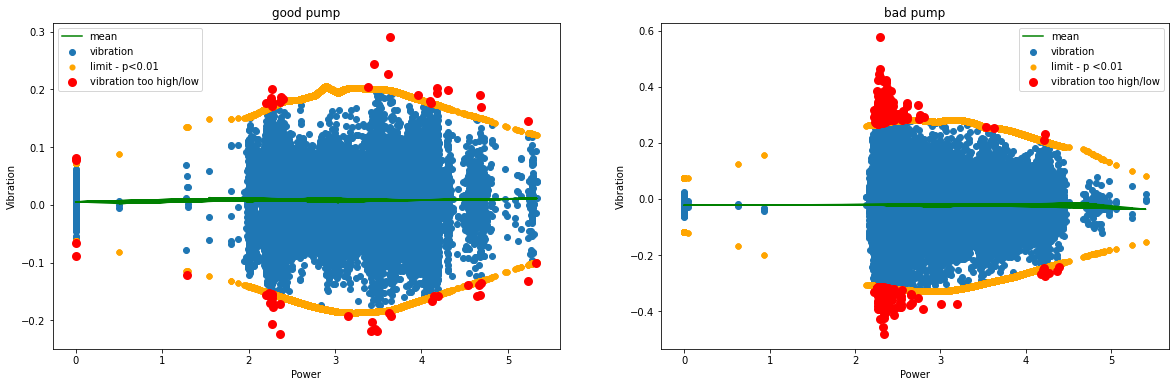

In [22]:
df_1 = df_i.loc['04714B6046D5'].copy()
df_2 = df_i.loc['04714B604101'].copy()

arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1
arr2 = np.where(df_2['Vx'] > df_2['predicted_Vx'] + df_2['pred_dev_Vx'], df_2['Vx'], 0) + \
       np.where(df_2['Vx'] < df_2['predicted_Vx'] - df_2['pred_dev_Vx'], df_2['Vx'], 0)
arr2[arr2 == 0] = np.nan
df_2['Anomaly'] = arr2
#df_1[df_1['Anomaly'] == 0] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'], label='vibration')
ax[0,0].plot(df_1['Ap'], df_1['predicted_Vx'], color='green', label='mean')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.01')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=3, label='vibration too high/low')
ax[0,0].set_xlabel('Power')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('good pump')

ax[0,1].scatter(df_2['Ap'], df_2['Vx'],  label='vibration')
ax[0,1].plot(df_2['Ap'], df_2['predicted_Vx'], color='green', label='mean')
ax[0,1].scatter(df_2['Ap'], df_2['predicted_Vx'] - df_2['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p <0.01')
ax[0,1].scatter(df_2['Ap'], df_2['predicted_Vx'] + df_2['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,1].scatter(df_2['Ap'], df_2['Anomaly'], color='red', lw=3, label='vibration too high/low')
ax[0,1].set_xlabel('Power')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('bad pump')


#plt.fill_between(df_1['Ap'], - df_1['pred_dev_Vx'], df_1['pred_dev_Vx'], alpha=0.2)

In [12]:
sz = 500
df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)
df_1['max_1'] = sp.ndimage.maximum_filter1d(df_1['Vx_1'], size=sz)
df_2['max_1'] = sp.ndimage.maximum_filter1d(df_2['Vx_1'], size=sz)



Text(0.5, 1.0, 'bad pump')

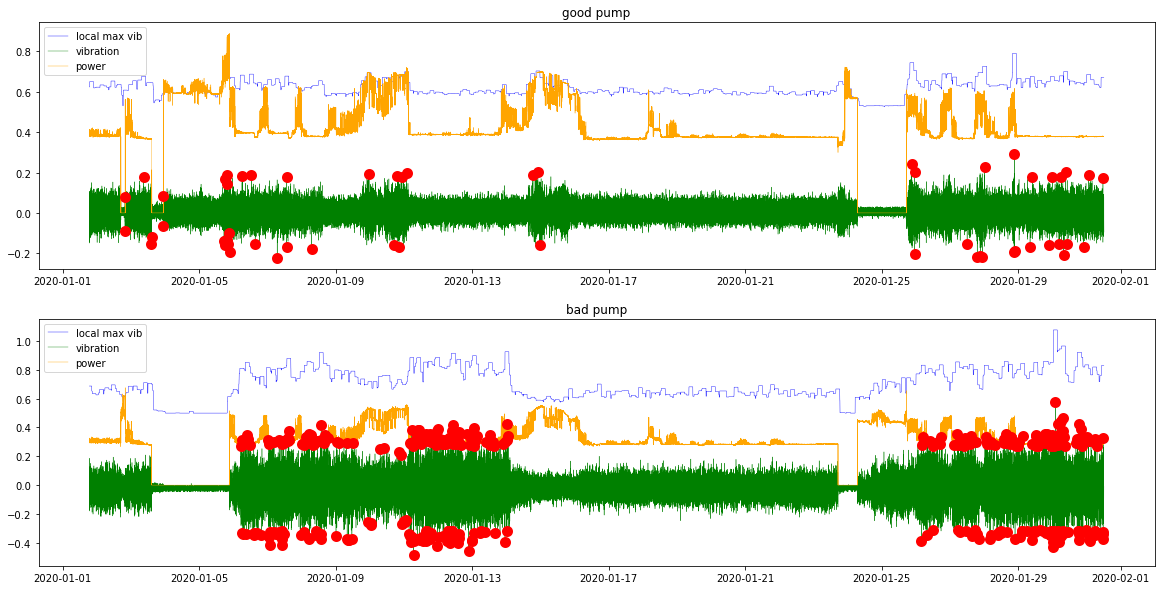

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), squeeze=False)
ax[0,0].plot(df_1['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
ax[0,0].plot(df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].plot(df_1['Ap']/6, lw=0.4, color='orange', label='power')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=5, color='red', zorder=10)
ax[0,0].legend()
ax[0,0].set_title('good pump')

ax[1,0].plot(df_2['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
ax[1,0].plot(df_2['Vx'], lw=0.4, color='green', label='vibration')
ax[1,0].plot(df_2['Ap']/8, lw=0.4, color='orange', label='power')
ax[1,0].scatter(df_2.index, df_2['Anomaly'], lw=5, color='red', zorder=10)
ax[1,0].legend()
ax[1,0].set_title('bad pump')


In [13]:
viai.active_models['04714B6046D5']

VI(
  (q_mu): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
  (q_log_var): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=35, bias=True)
    (3): ReLU()
    (4): Linear(in_features=35, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [6]:
df_i = df_input #.head(10000)

In [7]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = KDEAnomalyScore(0.000001, ['Ap'], ['Vx'], ['Vx_pred'])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()


2020-11-13T15:49:57.434 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-11-13T15:49:57.435 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-11-13T15:49:57.435 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-13T15:49:57.436 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-13T15:49:57.437 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KDEAnomalyScore_20201113144957
2020-11-13T15:49:57.438 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-13T15:49:57.438 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-13T15:49:57.438 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-13T15:49:57.439 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KDEANOMALYSCORE
Fu

<ipython-input-7-f107a4e8832c>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  get_ipython().run_cell_magic('time', '', "# Now run the anomaly functions as if they were executed in a pipeline\nEngineLogging.configure_console_logging(logging.DEBUG)\njobsettings = { 'db': db, \n               '_db_schema': 'public', 'save_trace_to_file' : True}\n\nspsi = KDEAnomalyScore(0.000001, ['Ap'], ['Vx'], ['Vx_pred'])\net = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)\nspsi._entity_type = et\ndf_i = spsi.execute(df=df_i)\n\nEngineLogging.configure_console_logging(logging.INFO)\ndf_i.describe()\n")


CPU times: user 31min 34s, sys: 1.09 s, total: 31min 35s
Wall time: 31min 40s


<ipython-input-7-f107a4e8832c>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  get_ipython().run_cell_magic('time', '', "# Now run the anomaly functions as if they were executed in a pipeline\nEngineLogging.configure_console_logging(logging.DEBUG)\njobsettings = { 'db': db, \n               '_db_schema': 'public', 'save_trace_to_file' : True}\n\nspsi = KDEAnomalyScore(0.000001, ['Ap'], ['Vx'], ['Vx_pred'])\net = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)\nspsi._entity_type = et\ndf_i = spsi.execute(df=df_i)\n\nEngineLogging.configure_console_logging(logging.INFO)\ndf_i.describe()\n")


,Vx,Vy,Vz,Ap,As,speed,Vx_1
count,257055.000000,257055.000000,257055.000000,257055.000000,257055.000000,257055.000000,257055.000000
mean,-0.006536,-0.027381,-0.959089,2.431164,0.970914,0.971130,-0.006535
std,0.061941,0.037634,0.073462,0.906289,0.289532,0.288927,0.061808
min,-0.481400,-0.359400,-1.415000,0.000000,0.000000,0.000000,-0.481400
25%,-0.034200,-0.044900,-0.999000,2.260000,1.032000,1.031694,-0.034200
50%,-0.003900,-0.027300,-0.960000,2.330200,1.037000,1.037000,-0.003900
75%,0.027300,-0.009800,-0.922900,2.687200,1.057000,1.058038,0.027300
max,0.575200,0.286100,-0.474600,5.401600,1.201000,1.195605,0.575200


In [8]:
import scipy as sp
sz = 500

df_i = df_i.reset_index().set_index('timestamp')

df_1 = df_i[df_i['entity'] == '04714B6046D5']
df_2 = df_i[df_i['entity'] == '04714B604101']
df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)
df_1['max_1'] = sp.ndimage.maximum_filter1d(df_1['Vx_1'], size=sz)
df_2['max_1'] = sp.ndimage.maximum_filter1d(df_2['Vx_1'], size=sz)



<ipython-input-8-7996b7afe03e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
<ipython-input-8-7996b7afe03e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)
<ipython-input-8-7996b7afe03e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

In [10]:
np.min(df_2['Vx_pred'])

0.0007634033139976949

In [11]:
df_1['red'] = np.where(df_1['Vx_pred'].values < 0.001, 1, np.nan)
df_2['red'] = np.where(df_2['Vx_pred'].values < 0.001, 1, np.nan)

<ipython-input-11-c826cca1167a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['red'] = np.where(df_1['Vx_pred'].values < 0.001, 1, np.nan)
<ipython-input-11-c826cca1167a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['red'] = np.where(df_2['Vx_pred'].values < 0.001, 1, np.nan)


Text(0.5, 1.0, 'bad pump')

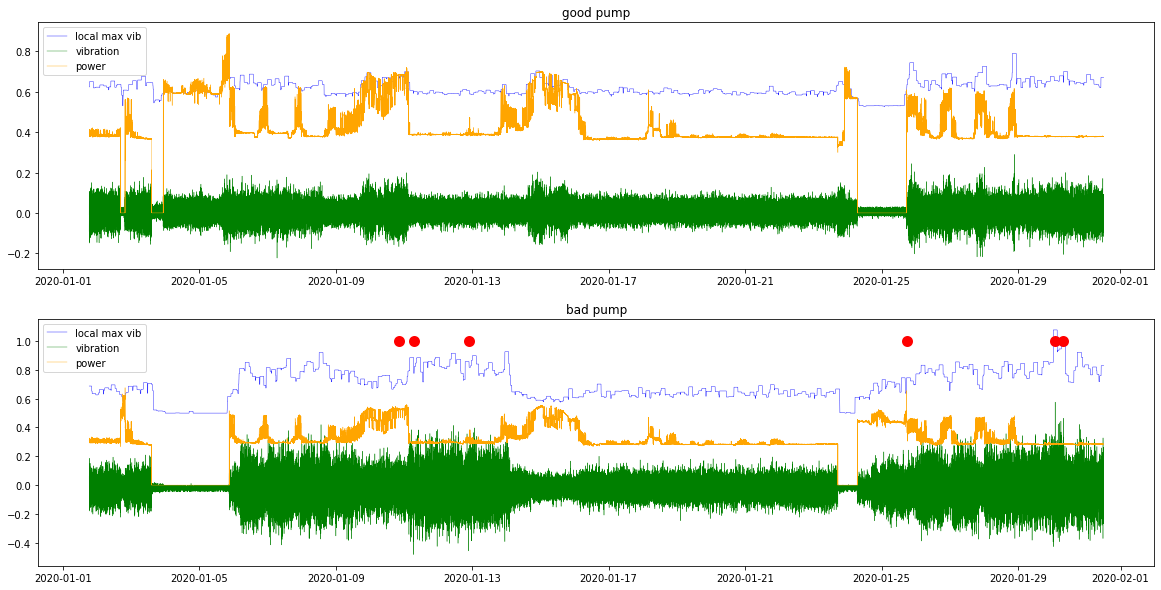

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), squeeze=False)
ax[0,0].plot(df_1['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
ax[0,0].plot(df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].plot(df_1['Ap']/6, lw=0.4, color='orange', label='power')
ax[0,0].scatter(df_1.index, df_1['red'], lw=5, color='red', zorder=10)
ax[0,0].legend()
ax[0,0].set_title('good pump')

ax[1,0].plot(df_2['max'] + 0.5, lw=0.4, color='blue', label='local max vib')
ax[1,0].plot(df_2['Vx'], lw=0.4, color='green', label='vibration')
ax[1,0].plot(df_2['Ap']/8, lw=0.4, color='orange', label='power')
ax[1,0].scatter(df_2.index, df_2['red'], lw=5, color='red', zorder=10)
ax[1,0].legend()
ax[1,0].set_title('bad pump')


In [18]:
# get estimators from spsi

kde1 = spsi.models['04714B6046D5']
kde2 = spsi.models['04714B604101']

grid = np.mgrid[0:5.5:0.02, -0.6:0.6:0.01].reshape(2,-1).T
grid.shape
zfull1 = kde1.pdf(grid)
zfull2 = kde2.pdf(grid)



In [19]:
# and compute densities for grid
xf1 = grid.T[0]
yf1 = grid.T[1]
xf2 = grid.T[0]
yf2 = grid.T[1]

yf1[zfull1 < 0.0001] = np.nan
yf2[zfull2 < 0.0001] = np.nan


In [20]:
z1 = df_1['Vx_pred'].values
z2 = df_2['Vx_pred'].values


idx1 = z1.argsort()
idx2 = z2.argsort()
x1, y1, z1 = df_1['Ap'][idx1], df_1['Vx'][idx1], z1[idx1]
x2, y2, z2 = df_2['Ap'][idx2], df_2['Vx'][idx2], z2[idx2]





<ipython-input-22-979f7e189dbb>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
<ipython-input-22-979f7e189dbb>:12: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,1].scatter(x2, y2, c=z2, s=50, edgecolor='', cmap='coolwarm')
<ipython-input-22-979f7e189dbb>:22: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[2,0].scatter(xf1, yf1, c=zfull1, s=50, edgecolor='', cmap='viridis')
<ipython-input-22-979f7e189dbb>:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[2,1].scatter(xf2, yf2, c=zfull2, s=50, edgecolor='', cmap='viridis')


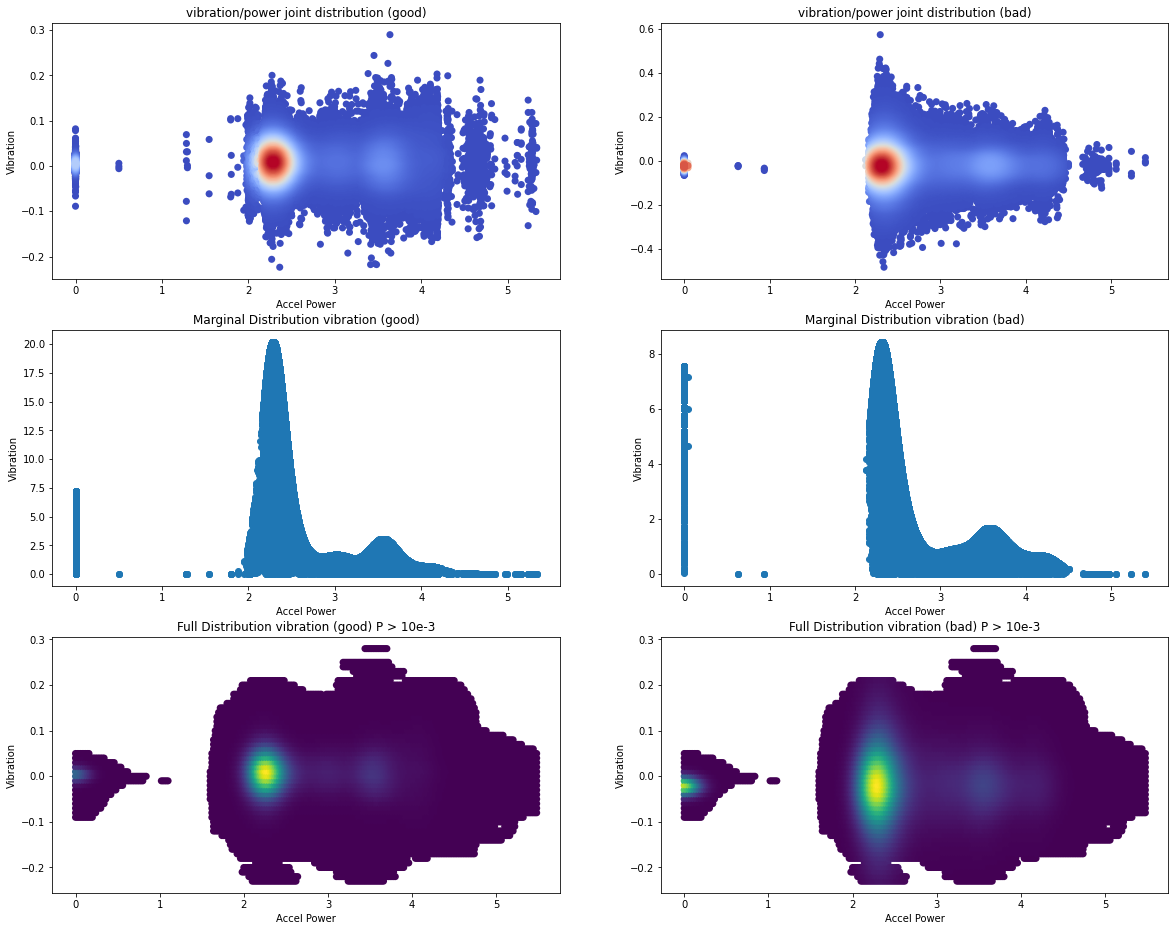

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(3, 2, figsize=(20, 16), squeeze=False)
#ax[0,0].scatter(df_1['Ap'], df_1['Vx'], color='green', lw=0.4)

ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
ax[0,0].set_title('vibration/power joint distribution (good)')


#ax[0,1].contour(x1, y1, z1, levels=z1_a, colors='red', linewidths=1)
#ax[1,0].scatter(df_2['Ap'], df_2['Vx'], color='green', lw=0.4)

ax[0,1].scatter(x2, y2, c=z2, s=50, edgecolor='', cmap='coolwarm')
ax[0,1].set_title('vibration/power joint distribution (bad)')


ax[1,0].scatter(x1, z1)
ax[1,0].set_title('Marginal Distribution vibration (good)')
ax[1,1].scatter(x2, z2)
ax[1,1].set_title('Marginal Distribution vibration (bad)')


ax[2,0].scatter(xf1, yf1, c=zfull1, s=50, edgecolor='', cmap='viridis')
ax[2,0].set_title('Full Distribution vibration (good) P > 10e-3')
ax[2,1].scatter(xf2, yf2, c=zfull2, s=50, edgecolor='', cmap='viridis')
ax[2,1].set_title('Full Distribution vibration (bad) P > 10e-3')
#ax[2,1].set_title('vibration/power \"cross entropy\" (bad)')

for i in (0,1,2):
    for j in (0,1):
        ax[i,j].set_xlabel('Accel Power')
        ax[i,j].set_ylabel('Vibration')


In [30]:
# save all stuff
df_i.to_csv("./df_i.csv")

In [31]:
df_1.to_csv("./df_1.csv")

In [32]:
df_2.to_csv("./df_2.csv")

In [38]:
np.save( "./zfull.npy", zfull1)

In [39]:
np.save( "./zfull2.npy", zfull2)

In [40]:
np.save("./grid.npy", grid)

#### Approximate with Gaussian

major contribution: gaussian along x/y coordinates, start with diagonal covariance matrix:

likelihood:

$e^{\frac{ {(\mu_0 - x)}^2}{\sigma_0} \frac{ {(\mu_1 - y)}^2}{\sigma_1}  }$


In [ ]:
# theta_0, theta_1 = mu_0/mu_1, theta_2/theta_3 = sigma_0/ sigma_1
def log_likelihood(theta, F, e):
    
    
    return np.sum(theta[0]
        
        np.log(2 * np.pi * (theta[1] ** 2 + theta[2] ** 2))
                         + (theta[0]) ** 2 / (theta[1] ** 2 + theta[2] ** 2))



def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)